In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Libraries

In [2]:
# import libraries
import os
import random
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy, TruePositives, FalsePositives, TrueNegatives,FalseNegatives, Precision, Recall, AUC 
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, GlobalMaxPooling2D, InputLayer, BatchNormalization, Dropout, Rescaling, Resizing 
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import L2, L1

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Import Data

In [3]:
base_dir="/kaggle/input/cat-and-dog"

In [4]:
train_directory = os.path.join(base_dir,"training_set","training_set")
test_directory = os.path.join(base_dir, "test_set","test_set")

In [5]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 224,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.4,
    "REGULARIZATION_RATE": 0.1,
    "N_FILTERS": 4,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 60,
    "N_DENSE_2": 10,
    "NUM_CLASSES": 2,
    "CLASS_NAMES": ["cats","dogs"]
}

In [6]:
# training data
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = train_directory,
    validation_split = 0.2,
    subset = "training",
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CONFIGURATION["CLASS_NAMES"],
    color_mode = 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle = True,
    seed = 99,
)

Found 8005 files belonging to 2 classes.
Using 6404 files for training.


In [7]:
# Extracting validation data from training data
val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = train_directory,
    validation_split = 0.2,
    subset = "validation",
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CONFIGURATION["CLASS_NAMES"],
    color_mode = 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle = True,
    seed = 99,
)

Found 8005 files belonging to 2 classes.
Using 1601 files for validation.


In [8]:
# training data
test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = test_directory,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CONFIGURATION["CLASS_NAMES"],
    color_mode = 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle = True,
    seed = 99,
)

Found 2023 files belonging to 2 classes.


# Reading Data

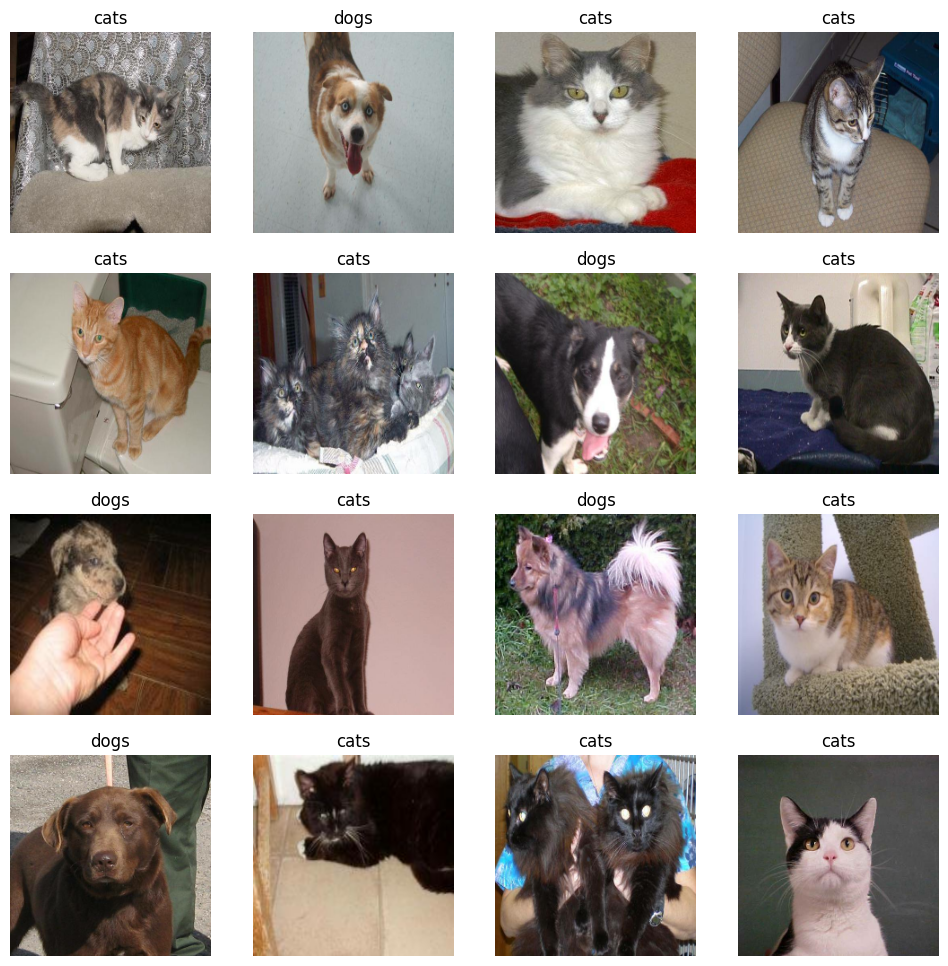

In [9]:
plt.figure(figsize=(12,12))

for images, labels in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255.)
        plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis=0).numpy()])
        plt.axis("off")

# Dataset Preparation

In [10]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [11]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [12]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255),
])

# Modeling

In [13]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (None,None, 3)),
    
    resize_rescale_layers,
    
    Conv2D(filters = CONFIGURATION['N_FILTERS'] , kernel_size = CONFIGURATION['KERNEL_SIZE'] , strides = CONFIGURATION['N_STRIDES'], activation = 'relu' , kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'], strides =CONFIGURATION['N_STRIDES']*2),
    
    Conv2D(filters = CONFIGURATION['N_FILTERS']*2+4 , kernel_size = CONFIGURATION['KERNEL_SIZE'] , strides = CONFIGURATION['N_STRIDES'], padding= "valid",activation = "relu" , kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'], strides =CONFIGURATION['N_STRIDES']*2),
    
    Flatten(),
    
    Dense(CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    
    Dense(CONFIGURATION['NUM_CLASSES'], activation="sigmoid")
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 4)       112       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 4)      16        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 4)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 12)      444       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 12)    

In [14]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
          BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [15]:
model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = "binary_crossentropy",
    metrics = metrics)

In [16]:
history = model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1,
    )

Epoch 1/20
201/201 [==============================] - 40s 150ms/step - loss: 1.6073 - tp: 3604.0000 - fp: 2376.0000 - tn: 4028.0000 - fn: 2800.0000 - accuracy: 0.5959 - precision: 0.6027 - recall: 0.5628 - auc: 0.6323 - val_loss: 1.2439 - val_tp: 763.0000 - val_fp: 795.0000 - val_tn: 806.0000 - val_fn: 838.0000 - val_accuracy: 0.4900 - val_precision: 0.4897 - val_recall: 0.4766 - val_auc: 0.5132
Epoch 2/20
201/201 [==============================] - 13s 64ms/step - loss: 1.0260 - tp: 3860.0000 - fp: 2197.0000 - tn: 4207.0000 - fn: 2544.0000 - accuracy: 0.6298 - precision: 0.6373 - recall: 0.6027 - auc: 0.6860 - val_loss: 1.0728 - val_tp: 708.0000 - val_fp: 677.0000 - val_tn: 924.0000 - val_fn: 893.0000 - val_accuracy: 0.5097 - val_precision: 0.5112 - val_recall: 0.4422 - val_auc: 0.5447
Epoch 3/20
201/201 [==============================] - 14s 67ms/step - loss: 0.9270 - tp: 3983.0000 - fp: 2135.0000 - tn: 4269.0000 - fn: 2421.0000 - accuracy: 0.6443 - precision: 0.6510 - recall: 0.6220 

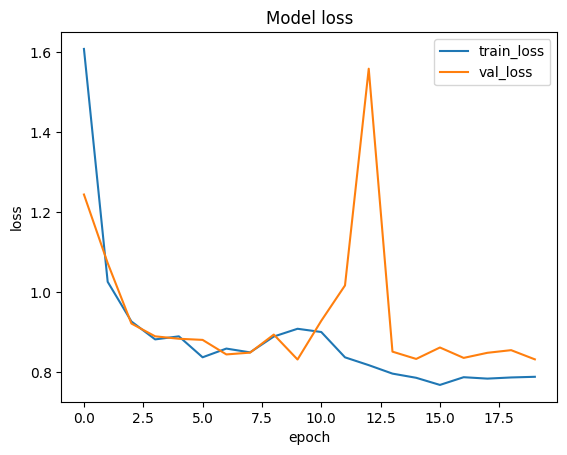

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

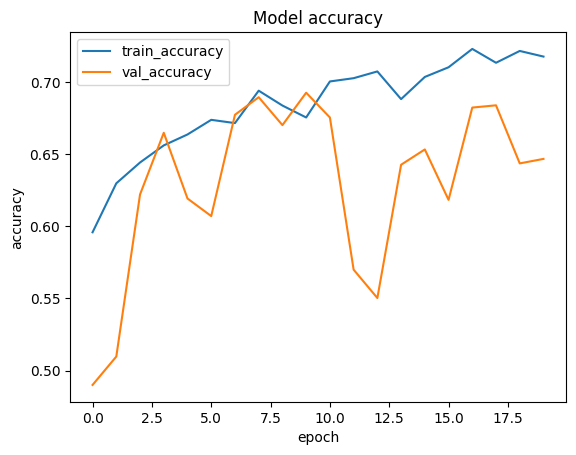

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model evaluation

In [25]:
model.evaluate(validation_dataset)

51/51 [==============================] - 3s 44ms/step - loss: 0.8324 - tp: 1064.0000 - fp: 594.0000 - tn: 1007.0000 - fn: 537.0000 - accuracy: 0.6468 - precision: 0.6417 - recall: 0.6646 - auc: 0.7283


[0.8323699831962585,
 1064.0,
 594.0,
 1007.0,
 537.0,
 0.6467832326889038,
 0.6417370438575745,
 0.6645846366882324,
 0.7283229231834412]

In [26]:
test_image = cv2.imread("/kaggle/input/cat-and-dog/test_set/test_set/cats/cat.4004.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))

im = tf.constant(test_image, dtype=tf.float32)
im = tf.expand_dims(im, axis = 0)
print(CONFIGURATION['CLASS_NAMES'][tf.argmax(model(im), axis=-1).numpy()[0]])

cats


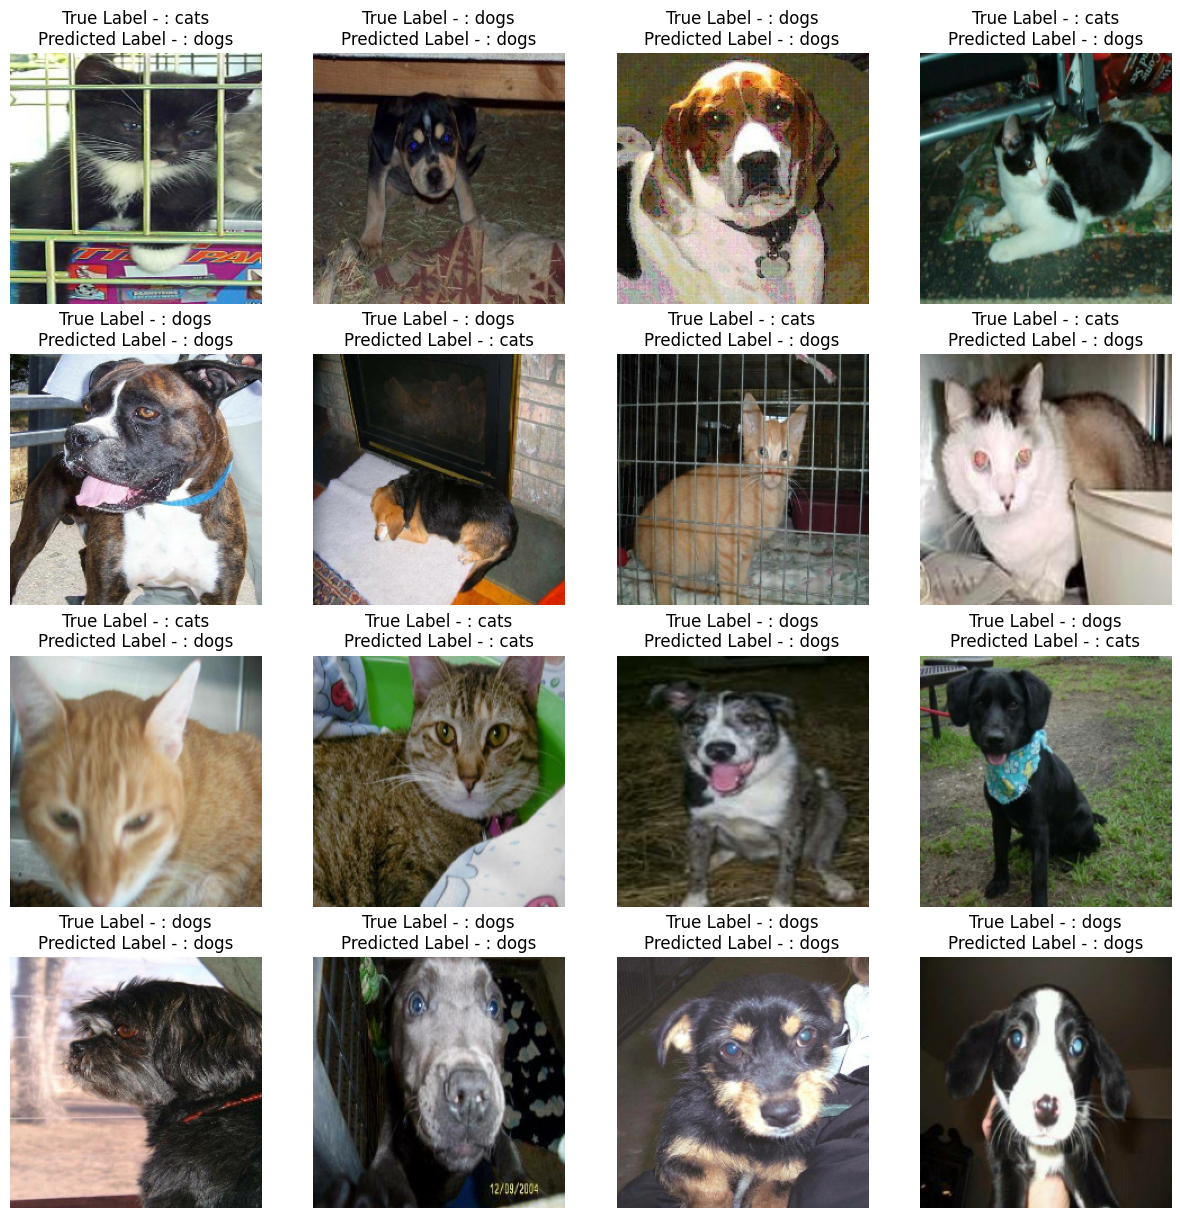

In [27]:
plt.figure(figsize = (15,15))

for images, labels in validation_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255.)
        
        plt.title("True Label - : " + CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = -1).numpy()] 
                  + "\n" + "Predicted Label - : " 
                  + CONFIGURATION["CLASS_NAMES"][int(tf.argmax(model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])])
        plt.axis("off")

# Confusion Matrix

In [78]:
inp = []
labels = []
for x,y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

In [42]:
labels=np.array([i[0] for i in labels])
print(labels[:5])

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [66]:
# inp[:1]

In [56]:
len(inp[0][0][0][0])

3

In [59]:
arr=np.array([np.array(xi) for xi in inp])

/tmp/ipykernel_28/81849784.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr=np.array([np.array(xi) for xi in inp])


In [57]:
len(inp.shape)

AttributeError: 'list' object has no attribute 'shape'

In [45]:
len(inp)

64

In [62]:
predicted = model.predict(np.array(inp[0]))
print(predicted[:,0])

1/1 [==============================] - 0s 113ms/step
[0.5105872  0.1879082  0.4886412  0.2001673  0.29760092 0.05097372
 0.07206768 0.3910134  0.29475555 0.07079252 0.35660893 0.6816005
 0.1194779  0.30256099 0.36773503 0.04356387 0.1350459  0.13854395
 0.5701506  0.12792863 0.48167208 0.00363649 0.4999948  0.7701624
 0.19083649 0.26413345 0.31180042 0.19755407 0.12573384 0.17020564
 0.51937973 0.17656414]


In [67]:
len(labels), len(inp)

(64, 64)

In [79]:
# labels

In [80]:
# predicted

In [82]:
# predicted = []
# labels = []
# threshold = 0.5
# cm = confusion_matrix(labels, predicted)
# print(cm)

# for im, label in validation_dataset:
#     predicted.append(im)
#     labels.append(label)
# print(predicted)
# print(labels)

In [24]:
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 
# cm_display.plot()
# plt.show() 

In [25]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [26]:
# Save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [27]:
# Load model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk
